## Проект e-commerce: вариант 1   
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:
1. Сколько у нас пользователей, которые совершили покупку только один раз?
2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
3. По каждому товару определить, в какой день недели товар чаще всего покупается.
4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.
###  
#### Файлы:
***olist_customers_datase.csv*** — таблица с уникальными идентификаторами пользователей
- customer_id — позаказный идентификатор пользователя (аналог номера паспорта)
- customer_unique_id —  уникальный идентификатор пользователя
- customer_zip_code_prefix —  почтовый индекс пользователя
- customer_city —  город доставки пользователя
- customer_state —  штат доставки пользователя

***olist_orders_dataset.csv*** —  таблица заказов
- order_id —  уникальный идентификатор заказа (номер чека)
- customer_id —  позаказный идентификатор пользователя (аналог номера паспорта)
- order_status —  статус заказа
- order_purchase_timestamp —  время создания заказа
- order_approved_at —  время подтверждения оплаты заказа
- order_delivered_carrier_date —  время передачи заказа в логистическую службу
- order_delivered_customer_date —  время доставки заказа
- order_estimated_delivery_date —  обещанная дата доставки

***olist_order_items_dataset.csv*** —  товарные позиции, входящие в заказы
- order_id —  уникальный идентификатор заказа (номер чека)
- order_item_id —  идентификатор товара внутри одного заказа
- product_id —  ид товара (аналог штрихкода)
- seller_id — ид производителя товара
- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
- price —  цена за единицу товара
- freight_value —  вес товара  

Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5   

**Уникальные статусы заказов в таблице olist_orders_dataset:**
- created —  создан
- approved —  подтверждён
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- shipped —  отгружен со склада
- delivered —  доставлен пользователю
- unavailable —  недоступен
- canceled —  отменён

In [101]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

%matplotlib inline

In [102]:
sns.set(rc={'figure.figsize':(13, 5)})

In [103]:
import requests
from urllib.parse import urlencode

In [104]:
#Считывание исходных данных - 3 таблицы.

In [105]:
users_public_key = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
orders_public_key = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
items_public_key = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

In [106]:
def get_yandex_download_url(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [107]:
users = pd.read_csv(get_yandex_download_url(users_public_key))
users.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [108]:
orders = pd.read_csv(get_yandex_download_url(orders_public_key))
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [109]:
items = pd.read_csv(get_yandex_download_url(items_public_key))
items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [110]:
#Осмотреть формат и название колонок, подготовить к работе
orders['order_purchase_timestamp']      = pd.to_datetime(orders.order_purchase_timestamp)
orders['order_approved_at']             = pd.to_datetime(orders.order_approved_at)
orders['order_delivered_carrier_date']  = pd.to_datetime(orders.order_delivered_carrier_date)
orders['order_delivered_customer_date'] = pd.to_datetime(orders.order_delivered_customer_date)
orders['order_estimated_delivery_date'] = pd.to_datetime(orders.order_estimated_delivery_date)
items['shipping_limit_date']            = pd.to_datetime(items.shipping_limit_date)

In [111]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

***Условия:***
Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. 
Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

Покупкой считается - Пользователь (customer_id) с чеком (order_id) и с Order_status = delivered


Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:
***Задание 1***. Сколько у нас пользователей, которые совершили покупку только один раз?

In [112]:
# создаем фрейм orders_active с заказами, у которых статус не 'created', не 'unavailable' и не 'canceled'
orders_active = orders[~orders['order_status'].isin(['created', 'canceled', 'unavailable'])]
orders_active.order_id.count()
# Всего было оплачено заказов:

98202

In [113]:
orders_active.nunique()

order_id                         98202
customer_id                      98202
order_status                         5
order_purchase_timestamp         97650
order_approved_at                89760
order_delivered_carrier_date     80951
order_delivered_customer_date    95658
order_estimated_delivery_date      447
dtype: int64

In [114]:
users.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [115]:
# создаем фрейм из таблицы users, c клиентами у которых customer_id пересекается с customer_id 
# в таблице orders_active. Фактически в users_active лежит фрейм со всеми клиентами, которые
# совершили хотя бы одну оплату заказа
users_active = orders_active.merge(users, on='customer_id', how='left')

In [116]:
users_active.nunique()

order_id                         98202
customer_id                      98202
order_status                         5
order_purchase_timestamp         97650
order_approved_at                89760
order_delivered_carrier_date     80951
order_delivered_customer_date    95658
order_estimated_delivery_date      447
customer_unique_id               94986
customer_zip_code_prefix         14964
customer_city                     4109
customer_state                      27
dtype: int64

In [117]:
# вычисляем количество уникальных пользователей во фрейме users_active, которые произвели 
# хотя бы одну покупку
num_uniq_active_users = users_active.customer_unique_id.nunique()
num_uniq_active_users

94986

In [118]:
# Смотрим распределение клиентов по количеству совершенных покупок
users_by_purchases = users_active.groupby('customer_unique_id') \
                                 .agg({'customer_id': 'count'}) \
                                 .rename(columns={'customer_id': 'purchases'})
users_by_purchases

,purchases
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1
0000f46a3911fa3c0805444483337064,1
0000f6ccb0745a6a4b88665a16c9f078,1
0004aac84e0df4da2b147fca70cf8255,1
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1
fffea47cd6d3cc0a88bd621562a9d061,1
ffff371b4d645b6ecea244b27531430a,1


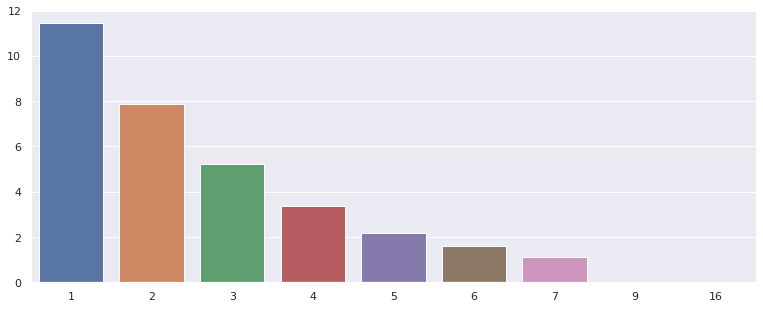

In [119]:
sns.barplot(y = np.log(users_by_purchases.purchases.value_counts().values),
            x = users_by_purchases.purchases.value_counts().index)

In [120]:
# вычисляем сколько клиентов совершили покупку (оплату) только один раз
num_users_one_purchase = (users_active.groupby('customer_unique_id') \
                          .agg({'customer_id': 'count'}) == 1).sum()

print(f'{num_users_one_purchase[0]} пользователей совершили покупку (хотя бы произвели оплату) только один раз')

92099 пользователей совершили покупку (хотя бы произвели оплату) только один раз


***Ответ на 1 задание: 92099 пользователей совершивших покупку только один раз.***

***Задание 2***. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
Создаю новый столбец для сортировки по месяцам

In [121]:
ls_dt = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
         'order_delivered_customer_date', 'order_estimated_delivery_date']
orders[ls_dt] = orders[ls_dt].apply(pd.to_datetime)

In [122]:
orders[orders.order_status == 'canceled'].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22
1058,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaT,2018-02-23
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17


In [123]:
orders_time_idx = orders.set_index('order_purchase_timestamp')
orders_time_idx.head()

,order_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_purchase_timestamp,,,,,,,
2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [124]:
df = orders_time_idx \
    .query("order_status == 'canceled' | order_status == 'unavailable'") \
    .groupby('order_status', as_index=True) \
    .resample(rule='M') \
    .order_id \
    .count() \
    .to_frame().reset_index().rename(columns={'order_purchase_timestamp': 'month', 'order_id': 'orders'})

df.month = df.month.dt.strftime("%Y %b")
df.head(3)

,order_status,month,orders
0,canceled,2016 Sep,2
1,canceled,2016 Oct,24
2,canceled,2016 Nov,0


[]

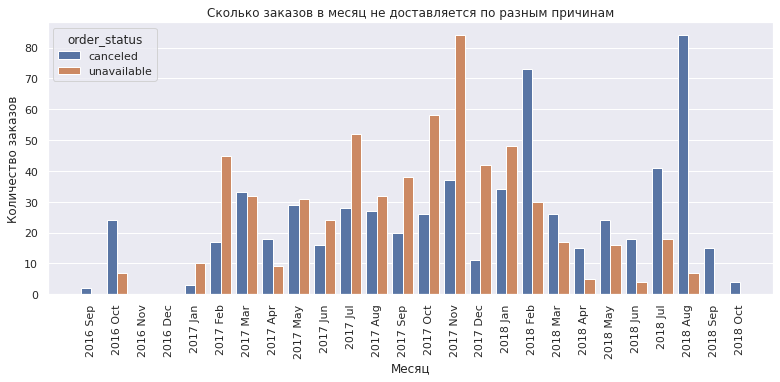

In [125]:
ax = sns.barplot(data=df, x='month', y='orders', hue='order_status')
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Месяц', ylabel='Количество заказов',
       title='Сколько заказов в месяц не доставляется по разным причинам')
ax.plot()

Ответ:

In [126]:
df.groupby('order_status', as_index=False).agg({'orders': 'mean'})

,order_status,orders
0,canceled,24.038462
1,unavailable,26.478261


***Задание 3***. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [127]:
# Перевожу дату создания заказы в дни недели
orders['day_of_week'] = orders['order_purchase_timestamp'].dt.day_name()

In [128]:
# Объединяю 2 таблицы по order_id, чтоб видеть дни недели и product_id
orders_items = pd.merge(orders, items, on='order_id', how='inner')
# Вывожу нужные мне столбцы
orders_product = orders_items[['order_id', 'product_id', 'day_of_week']]

In [129]:
# Группирую товар и день недели, считаю кол-во покупок
product_week = orders_product.groupby(['product_id', 'day_of_week']).size().reset_index(name='count')

***Ответ на 3 задание:***

In [130]:
# Вывожу в какой день недели больше всего берут определенный товар, сортирую по убыванию
product_week_most_buy = product_week.loc[product_week.groupby('product_id')['count'].idxmax()]
product_week_most_buy.sort_values('count', ascending=False)

,product_id,day_of_week,count
15902,422879e10f46682990de24d770e7f83d,Wednesday,93
36513,99a4788cb24856965c36a24e339b6058,Monday,92
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
20127,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
12998,368c6c730842d78016ad823897a372db,Friday,67
...,...,...,...
23676,62b07aff118f62756ee579afeedc3eb0,Thursday,1
23675,62ae6a8f5789aec14529a277c7516def,Sunday,1
23669,62abef05dddbd149514e4339c84f7d7d,Sunday,1
23667,62a6991adbb1e60f5c03a77fae5568ff,Monday,1


In [131]:
# Хотел удостовериться количеством уникальных продуктов. Совпадают.
items.product_id.nunique()

32951

***Задание 4***. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
Не стоит забывать, что внутри месяца может быть не целое количество недель. 
Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [132]:
orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,day_of_week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,Monday


In [134]:
users.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [135]:
orders_users = pd.merge(orders, users, how="left", on="customer_id")

In [136]:
orders_users.set_index('order_purchase_timestamp', inplace=True)

In [137]:
orders_users.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
day_of_week                          7
customer_unique_id               96096
customer_zip_code_prefix         14994
customer_city                     4119
customer_state                      27
dtype: int64

In [138]:
orders_users.head(3)

,order_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,day_of_week,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
order_purchase_timestamp,,,,,,,,,,,,
2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,Monday,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,Tuesday,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,Wednesday,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO


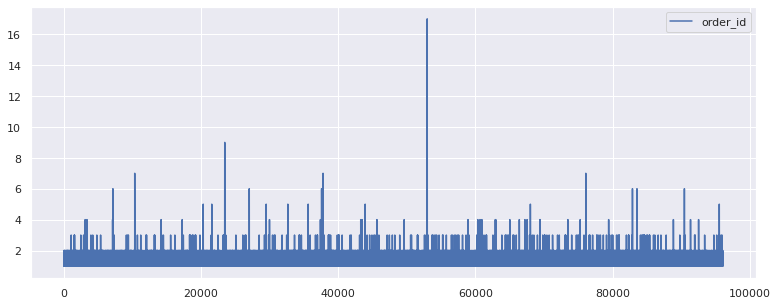

In [139]:
# Количество заказов у каждого пользователя
orders_users \
    .groupby('customer_unique_id', as_index=False) \
    .order_id.count() \
    .plot()

In [140]:
orders_users_3cols = orders_users[['customer_unique_id', 'customer_id', 'order_id']].sort_index()
orders_users_3cols.head(3)

,customer_unique_id,customer_id,order_id
order_purchase_timestamp,,,
2016-09-04 21:15:19,b7d76e111c89f7ebf14761390f0f7d17,08c5351a6aca1c1589a38f244edeee9d,2e7a8482f6fb09756ca50c10d7bfc047
2016-09-05 00:15:34,4854e9b3feff728c13ee5fc7d1547e92,683c54fc24d40ee9f8a6fc179fd9856c,e5fa5a7210941f7d56d0208e4e071d35
2016-09-13 15:24:19,009b0127b727ab0ba422f6d9604487c7,622e13439d6b5a0b486c435618b2679e,809a282bbd5dbcabb6f2f724fca862ec


In [141]:
customer_orders_per_month2 = orders_users_3cols.reset_index()
# добавляем колонку с датой в формате 2016-Sep
customer_orders_per_month2.insert(loc=1, column='year_month', 
                value=customer_orders_per_month2.order_purchase_timestamp.dt.strftime('%Y-%b'))
customer_orders_per_month2.head()

,order_purchase_timestamp,year_month,customer_unique_id,customer_id,order_id
0,2016-09-04 21:15:19,2016-Sep,b7d76e111c89f7ebf14761390f0f7d17,08c5351a6aca1c1589a38f244edeee9d,2e7a8482f6fb09756ca50c10d7bfc047
1,2016-09-05 00:15:34,2016-Sep,4854e9b3feff728c13ee5fc7d1547e92,683c54fc24d40ee9f8a6fc179fd9856c,e5fa5a7210941f7d56d0208e4e071d35
2,2016-09-13 15:24:19,2016-Sep,009b0127b727ab0ba422f6d9604487c7,622e13439d6b5a0b486c435618b2679e,809a282bbd5dbcabb6f2f724fca862ec
3,2016-09-15 12:16:38,2016-Sep,830d5b7aaa3b6f1e9ad63703bec97d23,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c
4,2016-10-02 22:07:52,2016-Oct,0eb1ee9dba87f5b36b4613a65074337c,b106b360fe2ef8849fbbd056f777b4d5,71303d7e93b399f5bcd537d124c0bcfa


In [142]:
# считаем количество заказов в группировке 'клиент' + 'месяц'
customer_orders_per_month_w = customer_orders_per_month2 \
    .groupby(['customer_unique_id', 'year_month'], as_index=True) \
    .agg({'order_id': 'count'}) \
    .reset_index() \
    .rename(columns={'order_id': 'orders_per_month'})

customer_orders_per_month_w.orders_per_month.value_counts()

1    96720
2     1267
3       51
4        7
6        1
Name: orders_per_month, dtype: int64

In [143]:
# добавляем колонку с datetime64 для дальнейших вычислений дней в месяце
customer_orders_per_month_w['month_dt'] = pd.to_datetime(customer_orders_per_month_w.year_month)
customer_orders_per_month_w.head()

,customer_unique_id,year_month,orders_per_month,month_dt
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-May,1,2018-05-01
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-May,1,2018-05-01
2,0000f46a3911fa3c0805444483337064,2017-Mar,1,2017-03-01
3,0000f6ccb0745a6a4b88665a16c9f078,2017-Oct,1,2017-10-01
4,0004aac84e0df4da2b147fca70cf8255,2017-Nov,1,2017-11-01


In [144]:
# считаем искомую метрику в группировке 'клиент' + 'месяц'.
customer_orders_per_month_w['orders_per_week'] = customer_orders_per_month_w.orders_per_month \
           / customer_orders_per_month_w.month_dt.dt.days_in_month.div(7)
customer_orders_per_month_w

,customer_unique_id,year_month,orders_per_month,month_dt,orders_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-May,1,2018-05-01,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-May,1,2018-05-01,0.225806
2,0000f46a3911fa3c0805444483337064,2017-Mar,1,2017-03-01,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-Oct,1,2017-10-01,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-Nov,1,2017-11-01,0.233333
...,...,...,...,...,...
98041,fffcf5a5ff07b0908bd4e2dbc735a684,2017-Jun,1,2017-06-01,0.233333
98042,fffea47cd6d3cc0a88bd621562a9d061,2017-Dec,1,2017-12-01,0.225806
98043,ffff371b4d645b6ecea244b27531430a,2017-Feb,1,2017-02-01,0.250000
98044,ffff5962728ec6157033ef9805bacc48,2018-May,1,2018-05-01,0.225806


In [145]:
customer_orders_per_month_w[customer_orders_per_month_w['customer_unique_id'] \
                            == customer_orders_per_month_w.customer_unique_id.value_counts().index[0]] \
                            .sort_values('month_dt')

,customer_unique_id,year_month,orders_per_month,month_dt,orders_per_week
54034,8d50f5eadf50201ccdcedfb9e2ac8455,2017-May,1,2017-05-01,0.225806
54033,8d50f5eadf50201ccdcedfb9e2ac8455,2017-Jun,1,2017-06-01,0.233333
54032,8d50f5eadf50201ccdcedfb9e2ac8455,2017-Jul,3,2017-07-01,0.677419
54031,8d50f5eadf50201ccdcedfb9e2ac8455,2017-Aug,1,2017-08-01,0.225806
54037,8d50f5eadf50201ccdcedfb9e2ac8455,2017-Sep,1,2017-09-01,0.233333
54036,8d50f5eadf50201ccdcedfb9e2ac8455,2017-Oct,2,2017-10-01,0.451613
54035,8d50f5eadf50201ccdcedfb9e2ac8455,2017-Nov,1,2017-11-01,0.233333
54040,8d50f5eadf50201ccdcedfb9e2ac8455,2018-May,2,2018-05-01,0.451613
54039,8d50f5eadf50201ccdcedfb9e2ac8455,2018-Jul,2,2018-07-01,0.451613
54038,8d50f5eadf50201ccdcedfb9e2ac8455,2018-Aug,3,2018-08-01,0.677419


[]

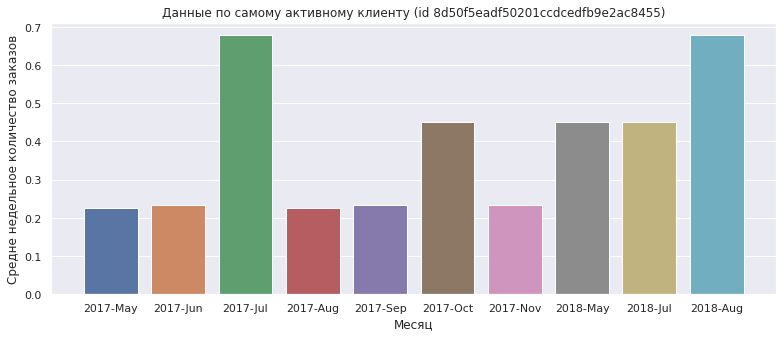

In [146]:
ax = sns.barplot(data = customer_orders_per_month_w[customer_orders_per_month_w['customer_unique_id'] \
                            == customer_orders_per_month_w.customer_unique_id.value_counts().index[0]] \
                                                                                .sort_values('month_dt'),
               x='year_month', y='orders_per_week')    
ax.set(xlabel='Месяц', ylabel='Средне недельное количество заказов',
       title='Данные по самому активному клиенту (id 8d50f5eadf50201ccdcedfb9e2ac8455)')
ax.plot()

#### Результат.
Получили колонку значений orders_per_week, содержащую  число покупок в неделю на каждого клиента по месяцам